In [1]:
%matplotlib inline

from collections import Counter, defaultdict, namedtuple, deque
from sortedcollections import ValueSortedDict
import itertools
import random
import copy

import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

from tqdm import tqdm_notebook
import networkx as nx
from graphviz import Digraph

# Solving Problems by Searching

* Atomic vs non-atomic repressentations
* Uninformed vs Informed

## Problem-Solving Agents

Steps:
* Goal formulation
* Problem formulation

## Example Problems

In [2]:
def space(p, progress_bar=False):
    if progress_bar:
        result = []
        with tqdm_notebook(generate_space(p)) as progress:
            for i, elem in enumerate(progress):
                result.append(elem)
                progress.set_postfix(num_created=f'{i+1:d}')
            return result
    return list(generate_space(p))

def generate_space(p):
    seen = {p.initial_state()}
    frontier = deque([p.initial_state()])
    yield p.initial_state()
    while frontier:
        s = frontier.popleft()
        for a in p.actions(s):
            new = p.result(s, a)
            if new not in seen:
                seen.add(new)
                frontier.append(new)
                yield new

def graph(p, limit=None):
    states = space(p) if limit is None else itertools.islice(generate_space(p), limit)
    return {
        state: {p.result(state, a): p.step_cost(state, a, p.result(state, a)) for a in p.actions(state)}
        for state in states
    }

### Machinarium Docks Hoist Puzzle

#### Prblem

![Docks Hoist Puzzle](./images/Mini-game_7.jpg)

#### Solution

![Docks Hoist Puzzle Solution](./images/Mini-game_7_walkthrough_book_hint.jpg)

#### Formulation

In [4]:
class DocksHoistPuzzle:
    @staticmethod
    def initial_state():
        return '>>> <<<'

    @staticmethod
    def actions(state):
        result = []
        if state.replace(' <', '< ') != state:
            result.append('left')
        if state.replace('> ', ' >') != state:
            result.append('right')
        if state.replace(' ><', '<> ') != state:
            result.append('jump-left')
        if state.replace('>< ', ' <>') != state:
            result.append('jump-right')
        return result

    @staticmethod
    def result(state, action):
        if action == 'left':
            return state.replace(' <', '< ')
        if action == 'right':
            return state.replace('> ', ' >')
        if action == 'jump-left':
            return state.replace(' ><', '<> ')
        if action == 'jump-right':
            return state.replace('>< ', ' <>')
        raise Exception(f'Unknown action {action}')

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return state == '<<< >>>'

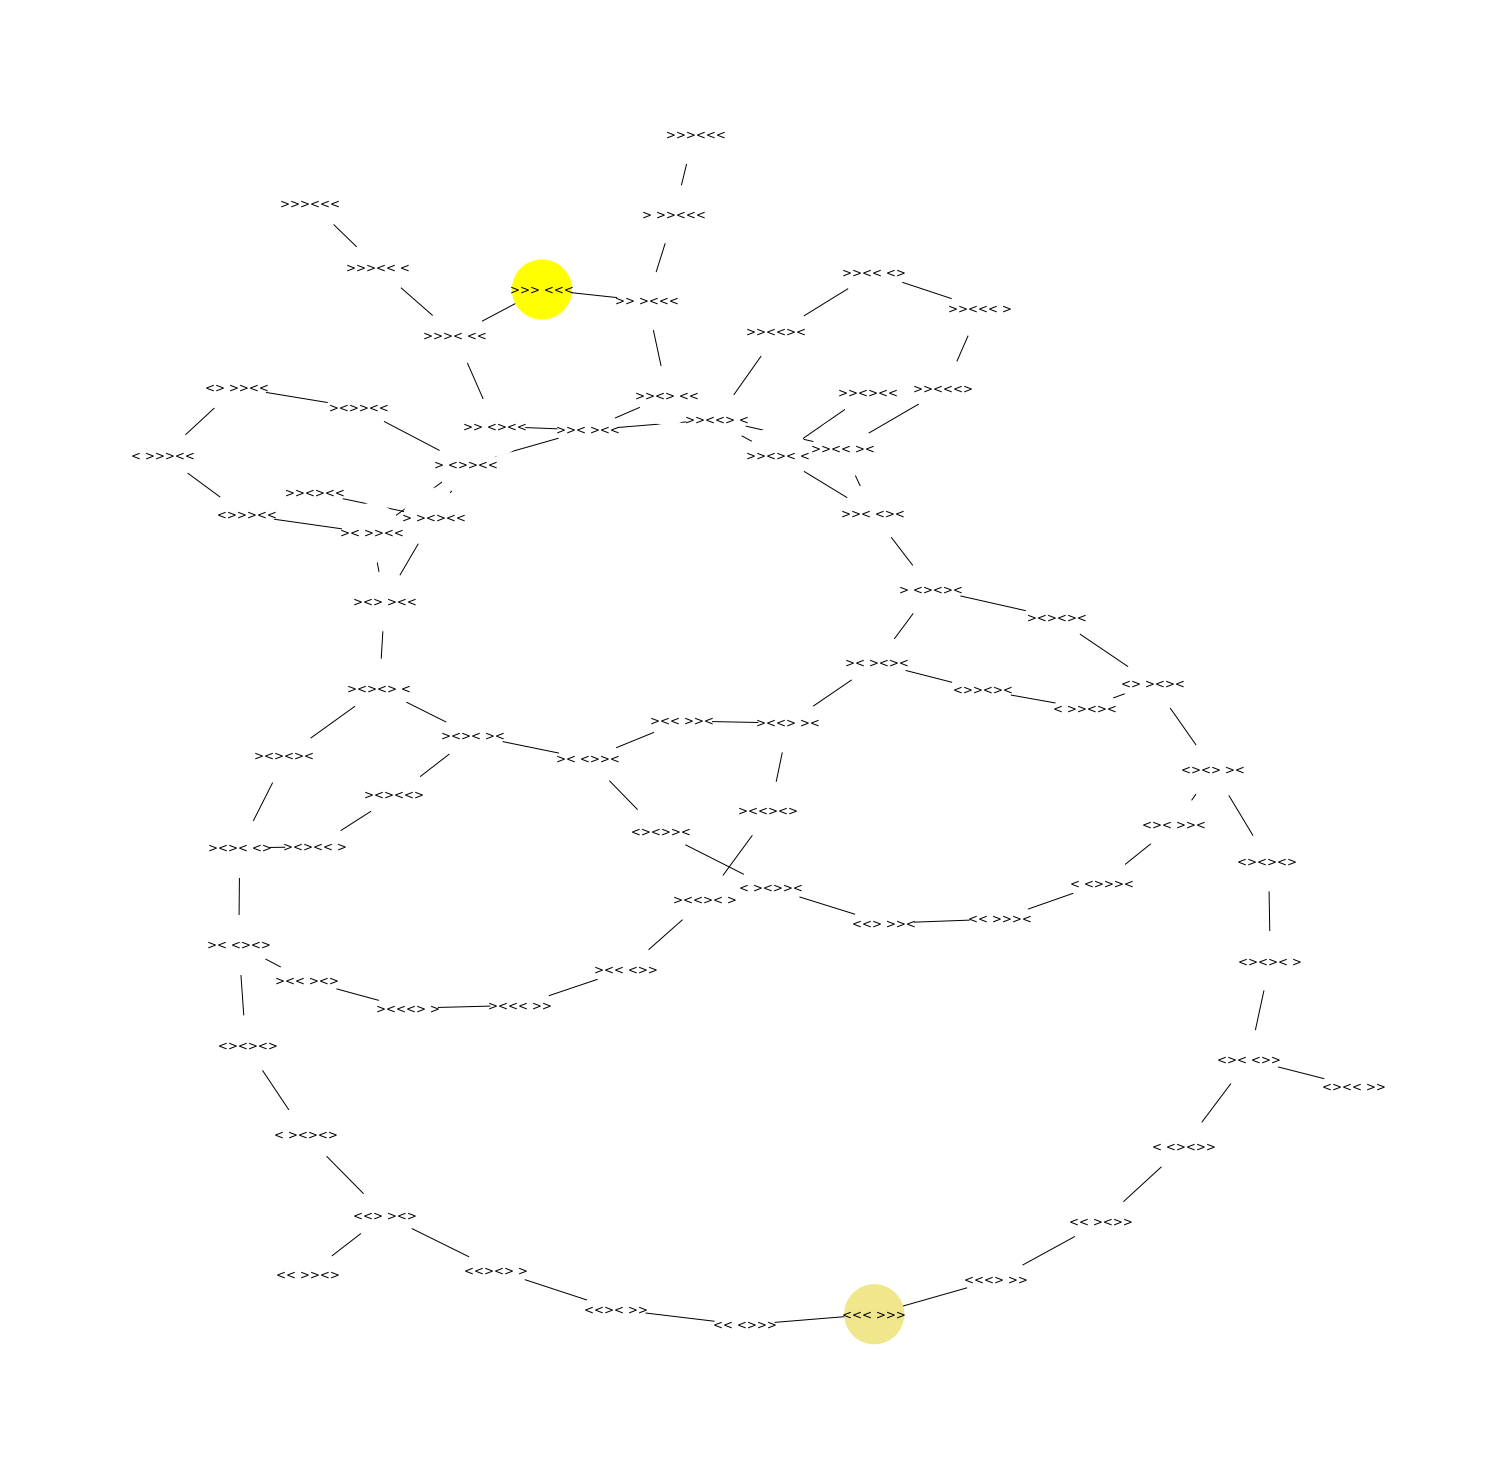

In [5]:
plt.figure(figsize=[20, 20])
g = nx.Graph()
g.add_weighted_edges_from([
    (source, dest, weight)
    for source, edges in graph(DocksHoistPuzzle).items()
    for dest, weight in edges.items()
])
g.add_node('>>> <<<')

nodes = list(g.nodes)
colors = ['white'] * len(nodes)
colors[nodes.index('>>> <<<')] = 'yellow'
colors[nodes.index('<<< >>>')] = 'khaki'

nx.draw_kamada_kawai(
    g, 
    with_labels=True, 
    node_size=3500, 
    node_color=colors
)

### Vacuum World

#### State

![Vacuum World State](./images/va1.png)

#### State Space

![Vacuum World State Space](./images/VacuumWorld.JPG)

#### Formulation

In [8]:
class VacuumWorld:
    @staticmethod
    def initial_state():
        #       location, left-dirty, right dirty
        return ('L'     , True      , True       )

    @staticmethod
    def actions(state):
        loc, ld, rd = state
        result = ['S']
        if loc == 'L':
            result.append('R')
        if loc == 'R':
            result.append('L')
        return result
        
    @staticmethod
    def result(state, action):
        loc, ld, rd = state
        if action == 'S':
            if loc == 'L':
                ld = False
            if loc == 'R':
                rd = False
        else:
            loc = action
        return (loc, ld, rd)

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return state[1:] == (False, False)

In [7]:
space(VacuumWorld)

[('L', True, True),
 ('L', False, True),
 ('R', True, True),
 ('R', False, True),
 ('R', True, False),
 ('R', False, False),
 ('L', True, False),
 ('L', False, False)]

In [44]:
bfs_search(VacuumWorld)

Solution(state=('R', False, False), solution=['S', 'R', 'S'], cost=3, num_expanded=9, max_memory=10)

In [9]:
dfs_search(VacuumWorld, graph=True)

Solution(state=('L', False, False), solution=['R', 'S', 'L', 'S'], cost=4, num_expanded=4, max_memory=6)

### Sliding Puzzle

#### Problem

![](./images/sliding_puzzle.png)

#### Formulation

In [10]:
class SlidingPuzzle:
    def __init__(
            self,
            board=(
                (7, 2, 4),
                (5, 0, 6),
                (8, 3, 1)
            )
        ):
        self.initial = board
    
    def initial_state(self):
        return self.initial

    def actions(self, state):
        r, c = [(row, cols.index(0)) for row, cols in enumerate(state) if 0 in cols][0]
        results = [
            ((r, c), (r+1, c)),
            ((r, c), (r, c+1)),
            ((r, c), (r-1, c)),
            ((r, c), (r, c-1)),
        ]
        return [
            ((r0, c0), (r1, c1) )
            for (r0, c0), (r1, c1) 
            in results 
            if (r1 in {0, 1, 2}) and (c1 in {0, 1, 2})
        ]
        
    def result(self, state, action):
        state = list(map(list, state))
        (r0, c0), (r1, c1) = action
        state[r0][c0], state[r1][c1] = state[r1][c1], state[r0][c0]
        return tuple(map(tuple, state))

    def step_cost(self, start, action, end):
        return 1

    def goal_test(self, state):
        return state == (
            (1, 2, 3),
            (4, 5, 6),
            (7, 8, 0)
        )

In [11]:
len(space(SlidingPuzzle()))

181440

In [14]:
bfs_search(SlidingPuzzle(), graph=True)

Solution(state=((1, 2, 3), (4, 5, 6), (7, 8, 0)), solution=[((1, 1), (2, 1)), ((2, 1), (2, 2)), ((2, 2), (1, 2)), ((1, 2), (1, 1)), ((1, 1), (1, 0)), ((1, 0), (0, 0)), ((0, 0), (0, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 2), (1, 1)), ((1, 1), (2, 1)), ((2, 1), (2, 0)), ((2, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 1), (0, 1)), ((0, 1), (0, 0)), ((0, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2))], cost=20, num_expanded=47864, max_memory=66607)

In [ ]:
dfs_search(SlidingPuzzle(), graph=True)

In [21]:
dls_search(SlidingPuzzle(), 25, graph=True)

### 8-Queens

#### Problem

![](./images/8-queens-unique_solutions.png)

In [10]:
class EightQueens:
    @staticmethod
    def initial_state():
        return ()

    @staticmethod
    def actions(state):
        if len(state) == 8:
            return []
        
        results = set(range(8))
        results -= set(state)
        
        altr_diag = {row + col for col, row in enumerate(state)}
        main_diag = {8 - row + col for col, row in enumerate(state)}
        
        for r in list(results):
            if (r + len(state)) in altr_diag:
                results.remove(r)
            elif (8 - r + len(state)) in main_diag:
                results.remove(r)
        
        return results
        
        
    @staticmethod
    def result(state, action):
        return state + (action,)

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return len(state) == 8

In [11]:
q = space(EightQueens)

In [12]:
def threneted_list(queens):
    size = len(queens)
    thretenings = len(queens) * [0]

    c = Counter(row + col for row, col in zip(range(size - 1, -1, -1), queens))
    for idx, (row, col) in enumerate(zip(range(size - 1, -1, -1), queens)):
        thretenings[idx] += c[row + col] - 1

    c = Counter(row + col for row, col in zip(range(0, size, 1), queens))
    for idx, (row, col) in enumerate(zip(range(0, size, 1), queens)):
        thretenings[idx] += c[row + col] - 1

    return thretenings

def to_chessboard(queens):
    size = len(queens)
    
    threats = np.zeros([size, size], dtype=np.int)
    
    board = np.ones([size, size])
    board[::2, ::2] = 1/20
    board[1::2, 1::2] = 1/20
    
    board[np.ogrid[:len(queens)], queens] = 0.5
    
    for row, (col, t) in enumerate(zip(queens, threneted_list(queens))):
        if t == 0:
            board[row, col] = 2 / 10
        else:
            board[row, col] = 3 / 10
            threats[row, col] = t
    
    return board, threats

def plot_chessboard(queens, text_size=15, animated=False):
    size = len(queens)
    
    ax = plt.gca()
    ax.set_xlim([-0.5, size - 0.5])
    ax.set_ylim([-0.5, size - 0.5])
    ax.set_xticks([])
    ax.set_yticks([])

    board, threats = to_chessboard(queens)
    image = plt.imshow(
        board, 
        interpolation='nearest', 
        cmap=plt.cm.tab20, 
        norm=matplotlib.colors.NoNorm(),
        animated=animated
    )
    
    if text_size:
        texts = []
        for i, row in enumerate(threats):
            row_texts = []
            for j, cell in enumerate(row):
                text = '' if cell == 0 else str(cell)
                row_texts.append(
                    ax.text(j, i, text, color='white', fontsize=text_size, animated=animated)
                )
            texts.append(row_texts)
        return image, texts
    else:
        return image

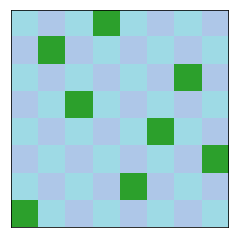

In [39]:
plot_chessboard(bfs_search(EightQueens()).state);

In [37]:
bfs_search(EightQueens())

Solution(state=(0, 4, 7, 5, 2, 6, 1, 3), solution=[0, 4, 7, 5, 2, 6, 1, 3], cost=8, num_expanded=1965, max_memory=573)

In [40]:
bfs_search(EightQueens(), graph=True)

Solution(state=(0, 4, 7, 5, 2, 6, 1, 3), solution=[0, 4, 7, 5, 2, 6, 1, 3], cost=8, num_expanded=1965, max_memory=2057)

In [41]:
dfs_search(EightQueens())

Solution(state=(7, 3, 0, 2, 5, 1, 6, 4), solution=[7, 3, 0, 2, 5, 1, 6, 4], cost=8, num_expanded=113, max_memory=19)

In [42]:
dfs_search(EightQueens(), graph=True)

Solution(state=(7, 3, 0, 2, 5, 1, 6, 4), solution=[7, 3, 0, 2, 5, 1, 6, 4], cost=8, num_expanded=113, max_memory=125)

In [43]:
ucs_search(EightQueens())

Solution(state=(7, 3, 0, 2, 5, 1, 6, 4), solution=[7, 3, 0, 2, 5, 1, 6, 4], cost=8, num_expanded=113, max_memory=125)

### Knuth's $\sqrt{x}$, $\lfloor x \rfloor$, $x!$

#### Problem

Every number can be obtained by applying:

* $\sqrt{x}$
* $\lfloor x \rfloor$
* $x!$

Repeatedly. starting by number 4.

For example:

$$ \lfloor \sqrt{\sqrt{\sqrt{\sqrt{\sqrt{(4!)!}}}}} \rfloor = 5 $$

#### Formulation

In [14]:
class KnuthProblem:
    @staticmethod
    def initial_state():
        return 4

    @staticmethod
    def actions(state):
        result = ['sqrt', 'floor']
        if isinstance(state, int):
            result.append('factorial')
        return result
        
    @staticmethod
    def result(state, action):
        import math
        if action == 'floor':
            return int(state)
        if action == 'sqrt':
            return math.sqrt(state)
        if action == 'factorial':
            n = 1
            for i in range(1, state + 1):
                n *= i
            return n
        raise Exception(f'Invalid action {action}')

    @staticmethod
    def step_cost(start, action, end):
        return 1

    @staticmethod
    def goal_test(state):
        return 5

In [14]:
sum(1 for x in itertools.islice(generate_space(KnuthProblem), 1000))

KeyboardInterrupt: 

#### The Challenge

Each path is infinite!

In [15]:
def factorial(k):
    n = 1
    for i in range(1, k+1):
        n *= i
    return n

In [16]:
def sqrtn(n, k):
    import math
    for i in range(k):
        n = math.sqrt(n)
    return n

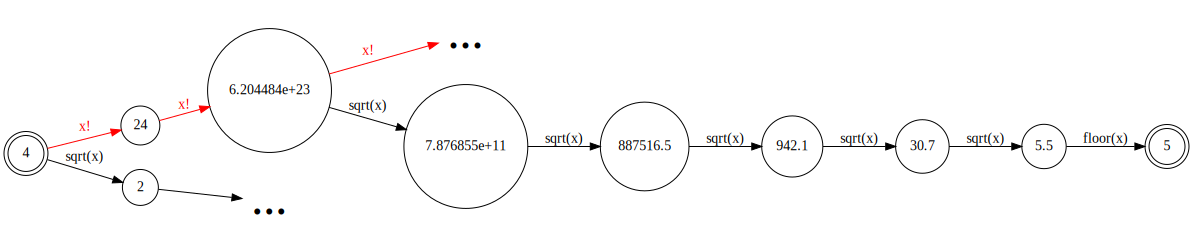

In [17]:
kg = Digraph(comment='DFS is Incomplete')
kg.attr(rankdir='LR')

f4 = str(factorial(4))
ff4 = f'{factorial(factorial(4)):e}'
sff4 = f'{sqrtn(factorial(factorial(4)), 1):e}'
ssff4 = f'{sqrtn(factorial(factorial(4)), 2):.1f}'
sssff4 = f'{sqrtn(factorial(factorial(4)), 3):.1f}'
ssssff4 = f'{sqrtn(factorial(factorial(4)), 4):.1f}'
sssssff4 = f'{sqrtn(factorial(factorial(4)), 5):.1f}'

kg.node('4', shape='doublecircle')
kg.node(f4, shape='circle')
kg.node(ff4, shape='circle')
kg.node('L1', '...', shape='plaintext', fontsize='50')
kg.node(sff4, shape='circle')
kg.node(ssff4, shape='circle')
kg.node(sssff4, shape='circle')
kg.node(ssssff4, shape='circle')
kg.node(sssssff4, shape='circle')
kg.node('5', shape='doublecircle')

kg.edge('4', f4, label='x!', color='red', fontcolor='red')
kg.edge(f4, ff4, label='x!', color='red', fontcolor='red')
kg.edge(ff4, 'L1', label='x!', color='red', fontcolor='red')
kg.edge(ff4, sff4, label='sqrt(x)')
kg.edge(sff4, ssff4, label='sqrt(x)')
kg.edge(ssff4, sssff4, label='sqrt(x)')
kg.edge(sssff4, ssssff4, label='sqrt(x)')
kg.edge(ssssff4, sssssff4, label='sqrt(x)')
kg.edge(sssssff4, '5', label='floor(x)')

kg.node('2', shape='circle')
kg.node('L2', '...', shape='plaintext', fontsize='50')
kg.edge('2', 'L2')
kg.edge('4', '2', label='sqrt(x)')

kg

### Rubik's Cube

#### Problem

![rubik 2x2](./images/2x2-stage4-position.jpg)

![rubik 2x2 faces](./images/2x2-Faces.jpg)

![rubik 2x2 moves](./images/2x2-moves.jpg)

** [photoes source](https://www.youcandothecube.com/solve-it/2-x-2-solution)

#### Formulation

In [18]:
Cube = namedtuple('Cube', 'left right up down front back')

goal_cube = Cube(
    left=(('R', 'R'), ('R', 'R')),
    right=(('O', 'O'), ('O', 'O')),
    up=(('W', 'W'), ('W', 'W')),
    down=(('Y', 'Y'), ('Y', 'Y')),
    front=(('B', 'B'), ('B', 'B')),
    back=(('G', 'G'), ('G', 'G')),
)

color_codes = {
    'G': 0 * 1/7,
    'R': 1 * 1/7,
    'O': 2 * 1/7,
    'W': 3 * 1/7,
    'Y': 4 * 1/7,
    'B': 5 * 1/7,
    'G': 6 * 1/7,
}

cmap = mcolors.ListedColormap([
    'grey',
    'red',
    'orange',
    'white',
    'yellow',
    'blue',
    'green'
])

def rotate_up(cube):
    return Cube(
        left=cube.left,
        right=cube.right,
        up=cube.front,
        down=cube.back,
        front=cube.down,
        back=cube.up,
    )

def rotate_down(cube):
    return Cube(
        left=cube.left,
        right=cube.right,
        up=cube.back,
        down=cube.front,
        front=cube.up,
        back=cube.down,
    )

def rotate_right(cube):
    return Cube(
        left=cube.back,
        right=cube.front,
        up=cube.up,
        down=cube.down,
        front=cube.left,
        back=cube.right,
    )

def rotate_left(cube):
    return Cube(
        left=cube.front,
        right=cube.back,
        up=cube.up,
        down=cube.down,
        front=cube.right,
        back=cube.left,
    )

def rotate_face_right(face):
    (a, b), (c, d) = face
    return (d, a), (b, c)

def perform_F(cube):
    up = list(cube.up)
    down = list(cube.down)
    left_t = list(zip(*cube.left))
    right_t = list(zip(*cube.right))
    
    up[1], left_t[1] = left_t[1], up[1]
    left_t[1], down[0] = down[0], left_t[1]
    down[0], right_t[0] = right_t[0], down[0]
    
    return Cube(
        left=tuple(zip(*left_t)),
        right=tuple(zip(*right_t)),
        up=tuple(up),
        down=tuple(down),
        front=rotate_face_right(cube.front),
        back=cube.back,
    )

def to_arr(box):
    (ul, ur), (ll, lr) = box
    return np.array([
        [color_codes[ll], color_codes[lr]],
        [color_codes[ul], color_codes[ur]]
    ])

def plot_cube(cube):
    mat = np.zeros((8, 6))
    mat[6:8, 2:4] = to_arr(cube.up)
    mat[4:6, 0:2] = to_arr(cube.left)
    mat[4:6, 2:4] = to_arr(cube.front)
    mat[4:6, 4:6] = to_arr(cube.right)
    mat[2:4, 2:4] = to_arr(cube.down)
    mat[0:2, 2:4] = to_arr(cube.back)
    
    plt.grid(True)
    plt.xticks(np.linspace(-.5, 5.5, 7))
    plt.yticks(np.linspace(-.5, 7.5, 9))
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlim([-.5, 5.5])
    plt.ylim([-.5, 7.5])
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=1, interpolation='nearest')

In [19]:
class RubliksCube:
    def __init__(self, difficulty=100):
        state = goal_cube
        for i in range(difficulty):
            actions = self.actions(state)
            action = random.choice(actions)
            state = self.result(state, action)
        self.initial = state
    
    def initial_state(self):
        return self.initial

    def actions(self, state):
        return [
            'rotate_left',
            'rotate_right',
            'rotate_up',
            'rotate_down',
            'perform_F'
        ]
        
    def result(self, state, action):
        if action == 'perform_F':
            return perform_F(state)
        if action == 'rotate_left':
            return rotate_left(state)
        if action == 'rotate_right':
            return rotate_right(state)
        if action == 'rotate_up':
            return rotate_up(state)
        if action == 'rotate_down':
            return rotate_down(state)
        raise Exception(f'Invalid Action "{action}"!')
        
    def step_cost(self, start, action, end):
        return 1

    def goal_test(self, state):
        return state == goal_cube

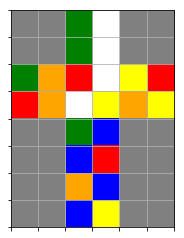

In [20]:
plot_cube(RubliksCube().initial_state())

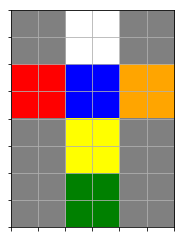

In [21]:
plot_cube(goal_cube)

#### Challenge

### Romania Navigation

#### Problem

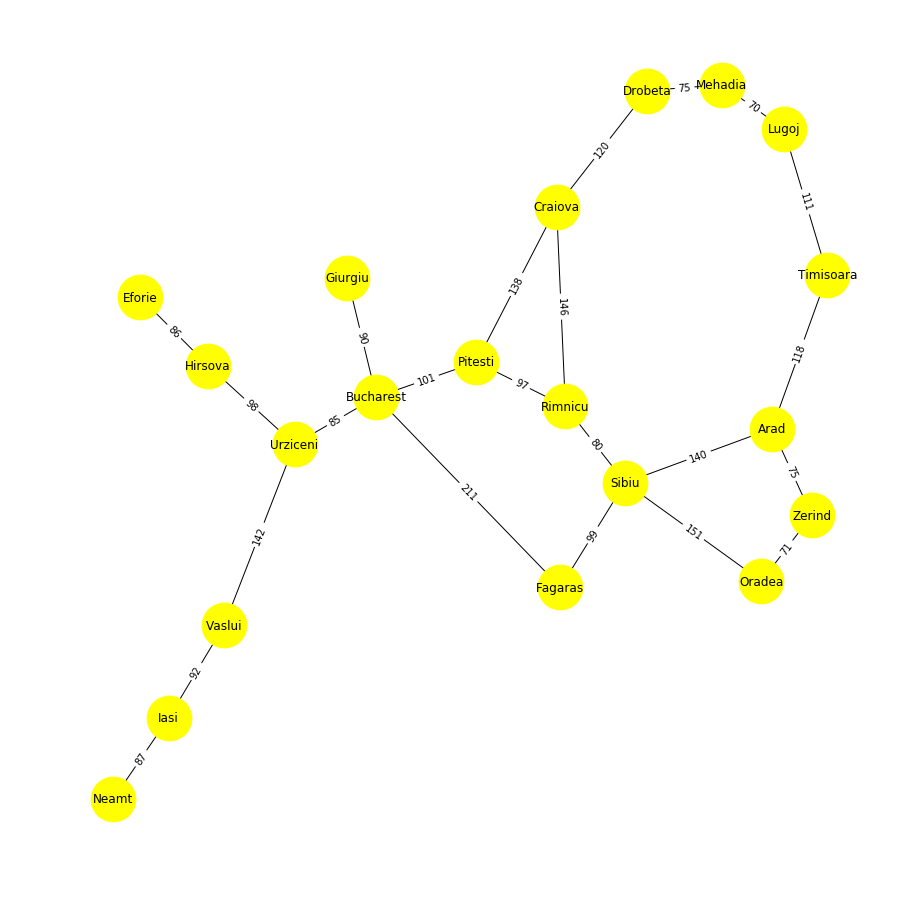

In [22]:
romania_map = dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142))

plt.figure(figsize=[12, 12])

g = nx.Graph()

nodes = set(romania_map.keys())
nodes |= set(y for x in romania_map.values() for y in x.keys())
nodes = list(nodes)
edges = [(s, d, w) for s, e in romania_map.items() for d, w in e.items()]

g.add_nodes_from(nodes)
g.add_weighted_edges_from(edges)

pos = nx.layout.kamada_kawai_layout(g)

nx.draw(
    g, 
    pos,
    with_labels=True,
    node_size=2000, 
    node_color='yellow'
)
nx.draw_networkx_edge_labels(
    g,
    pos,
    edge_labels={
        (s, d): w
        for s, d, w
        in edges
    }
);

#### Formulation

In [23]:
romania_adj = defaultdict(dict)
for source, adjs in romania_map.items():
    for dest, weight in adjs.items():
        romania_adj[source][dest] = weight
        romania_adj[dest][source] = weight

In [24]:
class RomaniaNavigation:
    def __init__(self, source='Arad', dest='Bucharest'):
        assert source in romania_adj
        assert dest in romania_adj
        self.source = source
        self.dest = dest
    
    def initial_state(self):
        return self.source

    def actions(self, state):
        return list(romania_adj[state].items())
        
    def result(self, state, action):
        target, cost = action
        return target
        
    def step_cost(self, start, action, end):
        target, cost = action
        return cost

    def goal_test(self, state):
        return state == self.dest

In [25]:
space(RomaniaNavigation())

['Arad',
 'Zerind',
 'Sibiu',
 'Timisoara',
 'Oradea',
 'Fagaras',
 'Rimnicu',
 'Lugoj',
 'Bucharest',
 'Craiova',
 'Pitesti',
 'Mehadia',
 'Urziceni',
 'Giurgiu',
 'Drobeta',
 'Hirsova',
 'Vaslui',
 'Eforie',
 'Iasi',
 'Neamt']

## Searching for Solutions

### Node, Queue, Stack

In [4]:
Node = namedtuple('Node', 'state parent action path_cost')
Solution = namedtuple('Solution', 'state solution cost num_expanded max_memory')

def child_node(problem, parent, action):
    state = problem.result(parent.state, action)
    return Node(
        state=state,
        parent=parent,
        action=action,
        path_cost=parent.path_cost + problem.step_cost(parent.state, action, state)
    )

def initial_node(problem):
    return Node(problem.initial_state(), None, None, 0)

def solution(node, num_expanded=None, max_memory=None):
    solution = []
    curr = node
    while True:
        if curr.parent is None:
            break
        solution.append(curr.action)
        curr = curr.parent
    solution.reverse()
    
    return Solution(
        state=node.state,
        solution=solution,
        cost=node.path_cost,
        num_expanded=num_expanded,
        max_memory=max_memory
    )

In [5]:
class Stack:
    def __init__(self):
        self._data = []
        self.states = set()
        
    def __bool__(self):
        return bool(self._data)
    
    def pop(self):
        node = self._data.pop()
        self.states.remove(node.state)
        return node
    
    def insert(self, node):
        self.states.add(node.state)
        return self._data.append(node)
    
    def __len__(self):
        return len(self._data)
    
    def __repr__(self):
        return f'Stack({self._data!r})'

In [6]:
class Queue:
    def __init__(self):
        self._data = deque()
        self.states = set()
    
    def __bool__(self):
        return bool(self._data)
    
    def pop(self):
        node = self._data.popleft()
        self.states.remove(node.state)
        return node
    
    def insert(self, node):
        self.states.add(node.state)
        return self._data.append(node)
    
    def __len__(self):
        return len(self._data)
    
    def __repr__(self):
        return f'Queue({self._data!r})'

In [7]:
class PriorityQueue:
    def __init__(self, key=lambda n: n.path_cost):
        self._data = ValueSortedDict(key)
        self.states = set()
    
    def __bool__(self):
        return bool(self._data)
    
    def pop(self):
        state, node = self._data.popitem()
        self.states.remove(state)
        return node
    
    def insert(self, node):
        self.states.add(node.state)
        self._data[node.state] = node
    
    def __len__(self):
        return len(self._data)
    
    def __repr__(self):
        return f'PriorityQueue({list(self._data)!r})'

### Measuring problem solving performance

* Completeness
* Optimality
* Time complexity
* Space complexity
* Branching factor
* Depth
* Search Cost
* Total Cost

## Uninformed Search

Informed search vs uninformed search

In [3]:
def tree_search(problem, frontier, cost_limit=None):
    num_expanded = 0
    max_memory = 0
    
    node = initial_node(problem)
    if problem.goal_test(node):
        return solution(
            node,
            num_expanded=num_expanded,
            max_memory=max_memory
        )
    
    frontier.insert(node)
    
    while frontier:
        max_memory = max(max_memory, len(frontier))
        
        node = frontier.pop()
        if problem.goal_test(node.state):
            return solution(
                node,
                num_expanded=num_expanded,
                max_memory=max_memory
            )
        
        num_expanded += 1
        for action in problem.actions(node.state):
            child = child_node(problem, node, action)
            if cost_limit and (child.path_cost >= cost_limit):
                continue
            frontier.insert(child)

            
def graph_search(problem, frontier, cost_limit=None):
    num_expanded = 0
    max_memory = 0
    
    node = initial_node(problem)
    if problem.goal_test(node):
        return solution(
            node,
            num_expanded=num_expanded,
            max_memory=max_memory
        )
    
    explored = set()
    frontier.insert(node)
    
    while frontier:   
        max_memory = max(max_memory, len(frontier) + len(explored))
        
        node = frontier.pop()
        if problem.goal_test(node.state):
            return solution(
                node,
                num_expanded=num_expanded,
                max_memory=max_memory
            )
        explored.add(node.state)
        
        num_expanded += 1
        for action in problem.actions(node.state):
            child = child_node(problem, node, action)
            if cost_limit and (child.path_cost >= cost_limit):
                continue
            if (child.state not in explored) and (child.state not in frontier.states):
                frontier.insert(child)

                
def dfs_search(problem, graph=False):
    return graph_search(problem, Stack()) if graph else tree_search(problem, Stack())


def bfs_search(problem, graph=False):
    return graph_search(problem, Queue()) if graph else tree_search(problem, Queue())


def ucs_search(problem):
    return graph_search(problem, PriorityQueue())


def dls_search(problem, cost_limit, graph=False):
    return graph_search(problem, Stack(), cost_limit=cost_limit) \
        if graph \
        else tree_search(problem, Stack(), cost_limit=cost_limit) 


def ids_search(problem):
    for i in itertools.count():
        pass

In [24]:
dls_search(SlidingPuzzle(), 90, graph=True)